In [1]:
!pip install googledrivedownloader

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple


In [2]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple


In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd
ids =["1rLxXeRWu7eLx11Ih_GQJa5LZQGjKCcYa", "1h6UL3QsMlageMcyiAJKl28Y98VX0MW6b", "1N7rUptJ-V1CCYjjUW2WFLW-DFEISy25m", "10WFJmpZyqGHFH2JeLe0JKEqnSBMJlG0-", "1-zzQZ6HCZowng_6ocsFGS55SAWkSXVzx"]
# https://drive.google.com/open?id=1N7rUptJ-V1CCYjjUW2WFLW-DFEISy25m
file_names = ["wiki.simple.vec","train.csv", "test.csv", "train_preprocessed.csv", "test_preprocessed.csv"]
for i in range(len(ids)):
  a = gdd.download_file_from_google_drive(file_id= ids[i],
                                      dest_path="./"+file_names[i],
                                      unzip=False)

In [0]:
from google.colab import files
# uploaded = files.upload()



In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
    100% |████████████████████████████████| 51kB 2.0MB/s 


In [6]:
import pandas as pd
import numpy as np
import copy
import codecs
import re
import seaborn as sns
import nltk

from nltk.corpus import stopwords
from collections import Counter

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Embedding, Input, Concatenate, Conv1D, Activation, TimeDistributed, Flatten, RepeatVector, Permute,multiply
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout, GRU, GlobalAveragePooling1D, MaxPooling1D, SpatialDropout1D, BatchNormalization
from keras.models import Model

from nltk import WordNetLemmatizer
import matplotlib.pyplot as plt


from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
original_train = pd.read_csv("train_preprocessed.csv")
original_train.shape
original_train.head(5)

original_test = pd.read_csv("test_preprocessed.csv")

In [0]:
original_train.to_csv('train_preprocessed_english.csv', index=False)
original_test.to_csv('test_preprocessed_english.csv', index=False)

In [0]:
original_train["comment_text"] = original_train["comment_text"].fillna(" ")
original_test["comment_text"] = original_test["comment_text"].fillna(" ")


In [13]:
original_train.head(5)
# original_test.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d'aww he matches this background colour i'm se...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i'm really not trying to edit war it's...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can't make any real suggestions on impr...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


In [15]:
train_data = original_train['comment_text'].tolist()
print (train_data[0])
for index, data in enumerate(train_data):
  if type(data) == float:
    print ("Its float at ", index, ' data is: ', data)
    
original_train['doc_len'] = original_train['comment_text'].apply(lambda words: len(words.split(" ")))


original_max_seq_len = np.round(original_train['doc_len'].mean() + original_train['doc_len'].std()).astype(int)


explanation why the edits made under my username hardcore metallica fan were reverted they weren't vandalisms just closure on some gas after i voted at new york dolls fac and please don't remove the template from the talk page since i'm retired now


In [16]:
original_train.shape

(159571, 9)

In [17]:
label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = original_train[label_names].values
print (y_train.shape)

print (np.max(original_train['doc_len']))

(159571, 6)
1403


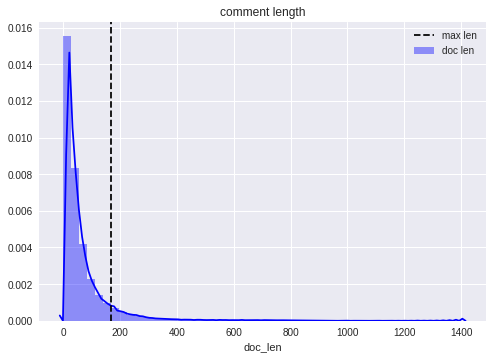

In [18]:
sns.distplot(original_train['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=original_max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length')
plt.legend()
plt.show()

In [19]:
original_train['doc_len'] = original_train['comment_text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(original_train['doc_len'].mean() + original_train['doc_len'].std()).astype(int)
print (max_seq_len)
# print (original_train.shape)

167


In [24]:
embeddings_index = {}
f = codecs.open('wiki.simple.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

111051it [00:16, 6820.17it/s]

found 111050 word vectors


In [0]:
raw_docs_train = original_train['comment_text'].tolist()
raw_docs_test = original_test['comment_text'].tolist() 
num_classes = len(label_names)

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])
processed_docs_train = []
for doc in tqdm(raw_docs_train):
#     tokens = tokenizer.tokenize(doc)
    tokens = doc.split(" ")
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))

processed_docs_test = []
for doc in tqdm(raw_docs_test):
#     tokens = tokenizer.tokenize(doc)
    tokens = doc.split(" ")
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for


100%|██████████| 153164/153164 [00:02<00:00, 74442.04it/s]


In [24]:
MAX_NB_WORDS = 100000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)

word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

dictionary size:  308611


In [25]:
print (word_index["fuck"])

4


In [0]:
 #pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)


In [0]:
#training params
batch_size = 256 
num_epochs = 8 

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4


In [28]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
# print ("nb_words", nb_words)
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 47275


In [29]:
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(7))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
# model.add(MaxPooling1D(7))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='sigmoid'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 167, 300)          30000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 167, 64)           134464    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 23, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 23, 64)            28736     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________________________________________

In [0]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [31]:
#model training
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

Train on 143613 samples, validate on 15958 samples
Epoch 1/8
 - 20s - loss: 0.1117 - acc: 0.9688 - val_loss: 0.0818 - val_acc: 0.9742
Epoch 2/8
 - 19s - loss: 0.0807 - acc: 0.9751 - val_loss: 0.0801 - val_acc: 0.9745
Epoch 3/8
 - 19s - loss: 0.0757 - acc: 0.9761 - val_loss: 0.0790 - val_acc: 0.9747
Epoch 4/8
 - 19s - loss: 0.0711 - acc: 0.9771 - val_loss: 0.0788 - val_acc: 0.9746
Epoch 5/8
 - 19s - loss: 0.0669 - acc: 0.9782 - val_loss: 0.0821 - val_acc: 0.9749
Epoch 00005: early stopping


In [0]:
y_test = model.predict(word_seq_test)


In [0]:
original_test.head(5)

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule is more succesful then you'll...
1,0000247867823ef7,from rfc the title is fine as it is imo
2,00013b17ad220c46,sources zawe ashton on lapland
3,00017563c3f7919a,if you have a look back at the source the info...
4,00017695ad8997eb,i don't anonymously edit articles at all


In [0]:
y_test.shape

(153164, 6)

In [0]:
#create a submission

submission_df = pd.DataFrame(columns=['id'] + label_names)
submission_df['id'] = original_test['id'].values
print (submission_df.shape)
# for index, label in enumerate(label_names):
#   print (index, label)
#   submission_df[label] = y_test[:,index]
#   print (y_test[:,index].shape)
submission_df[label_names] = y_test 
submission_df.to_csv("./regex_cnn_fasttext_submission.csv", index=False)

print (submission_df.head(5))


(153164, 7)
                 id      toxic severe_toxic     obscene       threat  \
0  00001cee341fdb12   0.994012       0.4254    0.953688    0.0710487   
1  0000247867823ef7  0.0228573  9.38191e-05  0.00650453  2.42506e-05   
2  00013b17ad220c46   0.175011    0.0173284   0.0915996   0.00982291   
3  00017563c3f7919a  0.0137629  6.78408e-06  0.00234201  9.23941e-07   
4  00017695ad8997eb   0.175011    0.0173284   0.0915996   0.00982291   

       insult identity_hate  
0    0.824344      0.205112  
1  0.00541125   0.000274741  
2    0.092048     0.0226814  
3  0.00189308   3.78509e-05  
4    0.092048     0.0226814  


In [0]:
ls


cnn_fasttext_submission.csv        test_preprocessed.csv
datalab/                           train.csv
nltk_data/                         train_preprocessed.csv
regex_cnn_fasttext_submission.csv  wiki.simple.vec
test.csv


In [0]:
files.download('regex_cnn_fasttext_submission.csv')

In [0]:
train = pd.read_csv("train_preprocessed.csv")
test = pd.read_csv("test_preprocessed.csv")


In [0]:
train["comment_text"] = train["comment_text"].fillna(" ")
test["comment_text"] = test["comment_text"].fillna(" ")


In [10]:
train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d'aww he matches this background colour i'm se...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i'm really not trying to edit war it's...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can't make any real suggestions on impr...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


In [0]:
list_sentences_train = train["comment_text"].fillna("").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("").values


In [12]:
print('mean text len:',train["comment_text"].str.count('\S+').mean())
print('max text len:',train["comment_text"].str.count('\S+').max())


mean text len: 67.14296457376341
max text len: 1403


In [0]:
min_count = 10 #the minimum required word frequency in the text
max_features = 27403 #it's from previous run with min_count=10
maxlen = 150 #padding length
num_folds = 3 #number of folds
batch_size = 512 
epochs = 4
embed_size = 300 #embeddings dimension


In [0]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train)) # + list(list_sentences_test)
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)


In [15]:
print('padding sequences')
X_train = {}
X_test = {}
X_train['text'] = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen, padding='post', truncating='post')
X_test['text'] = sequence.pad_sequences(list_tokenized_test, maxlen=maxlen, padding='post', truncating='post')

padding sequences


In [16]:
print('numerical variables')
train['num_words'] = train.comment_text.str.count('\S+')
test['num_words'] = test.comment_text.str.count('\S+')
train['num_comas'] = train.comment_text.str.count('\.')
test['num_comas'] = test.comment_text.str.count('\.')
train['num_bangs'] = train.comment_text.str.count('\!')
test['num_bangs'] = test.comment_text.str.count('\!')
train['num_quotas'] = train.comment_text.str.count('\"')
test['num_quotas'] = test.comment_text.str.count('\"')
train['avg_word'] = train.comment_text.str.len() / (1 + train.num_words)
test['avg_word'] = test.comment_text.str.len() / (1 + test.num_words)

numerical variables


In [0]:
count_train = pd.read_csv("train.csv")
count_test = pd.read_csv("test.csv")
eng_stopwords = set(stopwords.words("english"))

In [0]:
train['capitals'] = count_train["comment_text"].apply(lambda comment: sum(1 for c in comment if c.isupper()))
test['capitals'] = count_test["comment_text"].apply(lambda comment: sum(1 for c in comment if c.isupper()))

train['total_length'] = count_train["comment_text"].apply(len)
test['total_length'] = count_test["comment_text"].apply(len)
train['stopwords'] = count_train["comment_text"].apply(lambda comment: sum(comment.count(w) for w in eng_stopwords))
test['stopwords'] = count_test["comment_text"].apply(lambda comment: sum(comment.count(w) for w in eng_stopwords))
train['stopwords_vs_length'] = train['stopwords'] / train['total_length']
test['stopwords_vs_length'] = test['stopwords'] / test['total_length']



repeated_threshold = 15
def count_repeated(text):
    text_splitted = text.split()
    word_counts = Counter(text_splitted)
    return sum(count for word, count in sorted(word_counts.items()) if count > repeated_threshold)
train['repeated_words'] = count_train["comment_text"].apply(lambda comment: count_repeated(comment))
test['repeated_words'] = count_test["comment_text"].apply(lambda comment: count_repeated(comment))

In [21]:
train['stopwords_vs_length']

0         0.541667
1         0.366071
2         0.682403
3         0.593248
4         0.537313
5         0.553846
6         0.000000
7         0.652174
8         0.559322
9         0.600000
10        0.560348
11        0.607143
12        0.498433
13        0.638584
14        0.575342
15        0.463934
16        0.438596
17        0.395833
18        0.593220
19        0.679545
20        0.567669
21        0.448276
22        0.572744
23        0.309278
24        0.551455
25        0.569767
26        0.600694
27        0.571429
28        0.487395
29        0.371795
            ...   
159541    0.604046
159542    0.530488
159543    0.637500
159544    0.473684
159545    0.523810
159546    0.589888
159547    0.400000
159548    0.185185
159549    0.040000
159550    0.554913
159551    0.530612
159552    0.467391
159553    0.559685
159554    0.565934
159555    0.613445
159556    0.526316
159557    0.673660
159558    0.574627
159559    0.641457
159560    0.607729
159561    0.610288
159562    0.

In [0]:
scaler = MinMaxScaler()
X_train['num_vars'] = scaler.fit_transform(train[['num_words','num_comas','num_bangs','num_quotas','avg_word', 'capitals', 'stopwords_vs_length', 'repeated_words']])
X_test['num_vars'] = scaler.transform(test[['num_words','num_comas','num_bangs','num_quotas','avg_word', 'capitals', 'stopwords_vs_length', 'repeated_words']])


In [0]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()


In [26]:
print('create embedding matrix')
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector


create embedding matrix


In [0]:
def get_model_cnn(X_train):
    global embed_size
    inp = Input(shape=(maxlen, ), name="text")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.2)(x)
    z = GlobalMaxPool1D()(x)
    x = GlobalMaxPool1D()(Conv1D(embed_size, 4, activation="relu")(x))
    x = Concatenate()([x,z,num_vars])
    x = Dropout(0.3)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=[inp,num_vars], outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [0]:
def get_model_cnn_lstm(X_train):
    global embed_size
    inp = Input(shape=(maxlen, ), name="text")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Conv1D(embed_size, 4, activation="relu")(x)
    x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
    x = GlobalMaxPooling1D()(x)
    x = Concatenate()([x,num_vars])
    x = Dropout(0.25)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=[inp,num_vars], outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [72]:
get_model_cnn_lstm(X_train)
print('start modeling')
scores = []
predict = np.zeros((test.shape[0],6))
oof_predict = np.zeros((train.shape[0],6))


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 150, 300)     8220900     text[0][0]                       
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 147, 300)     360300      embedding_22[0][0]               
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 147, 100)     140400      conv1d_22[0][0]                  
__________________________________________________________________________________________________
global_max

In [64]:
kf = KFold(n_splits=num_folds, shuffle=True, random_state=239)
for train_index, test_index in kf.split(X_train['num_vars']):
    print (train_index)
    kfold_X_train = {}
    kfold_X_valid = {}
    y_train,y_test = y[train_index], y[test_index]
    for c in ['text','num_vars']:
        kfold_X_train[c] = X_train[c][train_index]
        kfold_X_valid[c] = X_train[c][test_index]

    model = get_model_cnn_lstm(X_train)
    model.fit(kfold_X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)
    predict += model.predict(X_test, batch_size=1000) / num_folds
    oof_predict[test_index] = model.predict(kfold_X_valid, batch_size=1000)
    cv_score = roc_auc_score(y_test, oof_predict[test_index])
    scores.append(cv_score)
    print('score: ',cv_score)


[     0      1      2 ... 159566 159569 159570]
Epoch 1/4
106380/106380 [==============================] - 205s 2ms/step - loss: 0.1092 - acc: 0.9692
Epoch 2/4
106380/106380 [==============================] - 203s 2ms/step - loss: 0.0525 - acc: 0.9813
Epoch 3/4
 26112/106380 [======>.......................] - ETA: 2:32 - loss: 0.0477 - acc: 0.9823

106380/106380 [==============================] - 203s 2ms/step - loss: 0.0454 - acc: 0.9832
Epoch 4/4
106380/106380 [==============================] - 202s 2ms/step - loss: 0.0417 - acc: 0.9843
score:  0.9776071326930151
[     0      1      2 ... 159567 159568 159570]
Epoch 1/4
 64512/106381 [=================>............] - ETA: 1:19 - loss: 0.1442 - acc: 0.9600

106381/106381 [==============================] - 200s 2ms/step - loss: 0.1148 - acc: 0.9660
Epoch 2/4
106381/106381 [==============================] - 197s 2ms/step - loss: 0.0517 - acc: 0.9815
Epoch 3/4
 93696/106381 [=========================>....] - ETA: 23s - loss: 0.0454 - acc: 0.9832

106381/106381 [==============================] - 197s 2ms/step - loss: 0.0453 - acc: 0.9832
Epoch 4/4
106381/106381 [==============================] - 196s 2ms/step - loss: 0.0414 - acc: 0.9845
score:  0.977101423928363
[     3      4      8 ... 159567 159568 159569]
Epoch 1/4
 10752/106381 [==>...........................] - ETA: 3:20 - loss: 0.2618 - acc: 0.9304

KeyboardInterrupt: ignored

In [43]:
  print('Total CV score is {}'.format(np.mean(scores)))    


Total CV score is nan


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [0]:
sample_submission = pd.DataFrame.from_dict({'id': test['id']})
oof = pd.DataFrame.from_dict({'id': train['id']})
for c in list_classes:
    oof[c] = np.zeros(len(train))
    sample_submission[c] = np.zeros(len(test))
    
sample_submission[list_classes] = predict
sample_submission.to_csv('submit_cnn_avg_' + str(num_folds) + '_folds_cap_st_rep.csv', index=False)

oof[list_classes] = oof_predict
oof.to_csv('cnn_'+str(num_folds)+'_oof.csv', index=False)

In [112]:
ls


cnn_3_oof.csv                          test_preprocessed_english.csv
datalab/                               train.csv
nltk_data/                             train_preprocessed.csv
submit_cnn_avg_3_folds_cap_st_rep.csv  train_preprocessed_english.csv
test.csv                               treu_submit_cnn_avg_3_folds.csv
test_preprocessed.csv                  wiki.simple.vec


In [0]:
files.download('submit_cnn_avg_3_folds_cap_st_rep.csv')